In [91]:
"""
Goal of this notebook is to take our x-ray png files and build a convolutional neural network to predict which images are part of 'findings' and which are part of 'no-findings'

Procedure and Outline

Loading the data
1. Use ImageDataGenerator to create augmentations of the data 
2. Split into training and validation subset

Training The Model
1. Load the pretrained models
2. Set trainable to False
3. Create a custom layer on top of this model -> Convolutional Layer, MaxPooling2D, Dense(128), Dense(1). 
4. * Experiment with dropout to see if it helps
5. Compile the model -> Set the learning rate (tf.keras.?.adam), loss='binary_crossentropy' since it is a binary classification problem, metric=['accuracy'] (or MatthewCorrelationCoefficient see step 1 of Testing)
6. Create history = model.fit(train=(X_train, y_train), validation=(X_val, y_val), epochs=5, verbose=1, batch_size=32)

Testing
1. Create a function to get the metric (using Matthew Correlation Coefficient) -> may have to do this prior to compiling the model and set this function as the metric. Look more into this, test both.
2. Create an array, y_test = model.predict(X_test)
3. Submit and see score

Assessment
Try to find weaknesses and see where you can Improve
"""

"\nGoal of this notebook is to take our x-ray png files and build a convolutional neural network to predict which images are part of 'findings' and which are part of 'no-findings'\n\nProcedure and Outline\n\nLoading the data\n1. Use ImageDataGenerator to create augmentations of the data \n2. Split into training and validation subset\n\nTraining The Model\n1. Load the pretrained models\n2. Set trainable to False\n3. Create a custom layer on top of this model -> Convolutional Layer, MaxPooling2D, Dense(128), Dense(1). \n4. * Experiment with dropout to see if it helps\n5. Compile the model -> Set the learning rate (tf.keras.?.adam), loss='binary_crossentropy' since it is a binary classification problem, metric=['accuracy'] (or MatthewCorrelationCoefficient see step 1 of Testing)\n6. Create history = model.fit(train=(X_train, y_train), validation=(X_val, y_val), epochs=5, verbose=1, batch_size=32)\n\nTesting\n1. Create a function to get the metric (using Matthew Correlation Coefficient) ->

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# image processing and augmentaiton
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# machine learning libraries
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization, Concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
train_file_path = '/kaggle/input/dataset/Train_PNG/Train_PNG'

datagen = ImageDataGenerator(
    rescale=1.0/255.00,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory = train_file_path,
    target_size = (512, 512),
    color_mode = 'rgb',
    class_mode = 'binary', 
    batch_size = 32,
    shuffle = True,
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    directory = train_file_path,
    target_size = (512, 512),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False,
    subset = 'validation'
)

Found 8001 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.


In [3]:
# used to find optimal learning rate faster

class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-6, max_lr=1e-4, step_size=2000., mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iterations = 0
        self.history = {}
        
    def on_train_begin(self, logs=None):
        logs = logs or {}
        # Use assign to set the learning rate properly
        self.model.optimizer.learning_rate.assign(self.base_lr)

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        lr = self._compute_lr()
        # Use assign to update the learning rate
        self.model.optimizer.learning_rate.assign(lr)
        self.history.setdefault('learning_rate', []).append(lr)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def _compute_lr(self):
        cycle = np.floor(1 + self.iterations / (2 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            scale_fn = lambda x: 1.
            scale_mode = 'cycle'
        else:
            raise ValueError('Mode not supported')
        return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * scale_fn(cycle)
  

In [4]:
input_layer = Input(shape=(512, 512, 3))

mobilenet_base = MobileNetV2(weights='imagenet', input_shape=(512, 512, 3), include_top=False)
densenet_base = DenseNet169(weights='imagenet', input_shape=(512, 512, 3), include_top=False)

# initially set the layers to not trainable
for layer in mobilenet_base.layers:
    layer.trainable=False
for layer in densenet_base.layers:
    layer.trainable=False

model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = Concatenate()([output_mobilenet, output_densenet])

x = BatchNormalization()(merged)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=x)

/tmp/ipykernel_36/1602177810.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', input_shape=(512, 512, 3), include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 16, 16,    │  2,257,984 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 16, 16,    │ 12,642,880 │ input_layer[0][0] │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2944)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2944)      │     11,776 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  3,015,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    262,400 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,190,977 (69.39 MB)

 Trainable params: 3,284,225 (12.53 MB)

 Non-trainable params: 14,906,752 (56.86 MB)

In [6]:
for layer in mobilenet_base.layers[-20:]:
    layer.trainable = True

for layer in densenet_base.layers[-10:]:
    layer.trainable = True


model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [7]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=1e-6
)

checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

clr = CyclicLR(
    base_lr = 1e-6,
    max_lr = 1e-4,
    step_size = 2000,
    mode='triangular'
)

In [8]:
model.load_weights('/kaggle/input/checkpoint/model_checkpoint.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
history = model.fit(
    train_generator,
    epochs=15,
    batch_size=32,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[checkpoint_callback, lr_reducer, early_stopping, clr]
)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8980 - loss: 0.2616
Epoch 1: val_accuracy did not improve from 0.90927
251/251 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - accuracy: 0.8980 - loss: 0.2616 - val_accuracy: 0.9055 - val_loss: 0.2516 - learning_rate: 6.3122e-05
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8997 - loss: 0.2425
Epoch 2: val_accuracy improved from 0.90927 to 0.91346, saving model to model_checkpoint.weights.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - accuracy: 0.8997 - loss: 0.2425 - val_accuracy: 0.9135 - val_loss: 0.2235 - learning_rate: 7.5547e-05
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9109 - loss: 0.2180
Epoch 3: val_accuracy did not improve from 0.91346
251/251 ━━━━━━━━━━━━━━━━━━━━ 731s 3s/step - accuracy: 0.9108 - loss: 0.2180 - val_accuracy: 0.8459 - val_loss: 0.4560 - learning_rate: 8.7972e-05
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9084 - loss: 0.2177
Epoch 4: val_accurac

In [12]:
model.load_weights('model_checkpoint.weights.h5')

In [13]:
model.save('best_model.h5')

In [14]:
test_file_path = '/kaggle/input/dataset/Test_PNG 2/Test_PNG'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    directory=test_file_path,
    target_size=(512, 512),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False
)

predictions = model.predict(test_generator)

Found 2000 images belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 983ms/step


In [15]:
from sklearn.metrics import roc_curve

# Predict on validation data
val_predictions = model.predict(validation_generator)
fpr, tpr, thresholds = roc_curve(validation_generator.labels, val_predictions)

# Find the threshold that gives the best F1 score or desired metric
# Example: maximizing tpr while minimizing fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')

# Use the optimal threshold
y_pred = np.where(predictions > optimal_threshold, 1, 0)
print(optimal_idx)

63/63 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step
Optimal Threshold: 0.2667831480503082
126


In [36]:
# could play around with this and see if it makes much difference in score
y_pred = np.where(predictions>0.45, 1, 0)

In [37]:
count0 = 0
count1 = 0
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        count0 +=1
    else:
        count1 += 1
print(count0 / len(y_pred))
print(count1 / len(y_pred))

0.705
0.295


In [38]:
from datetime import datetime

y_submission = pd.read_csv('/kaggle/input/dataset/data (4).csv')
y_submission = y_submission[-2000:].reset_index(drop=True)
y_submission.loc[0:1999, 'Finding'] = y_pred
y_submission['id'] = y_submission['id'].apply(lambda x: str(x).zfill(5))
y_submission.rename(columns={'Finding': 'Outcome'}, inplace=True)
y_submission['Outcome'] = y_submission['Outcome'].astype(int)
y_submission

y_submission.to_csv(f"submit_{datetime.today().strftime('%Y-%m-%d_%H%M%S')}.csv", index=False)

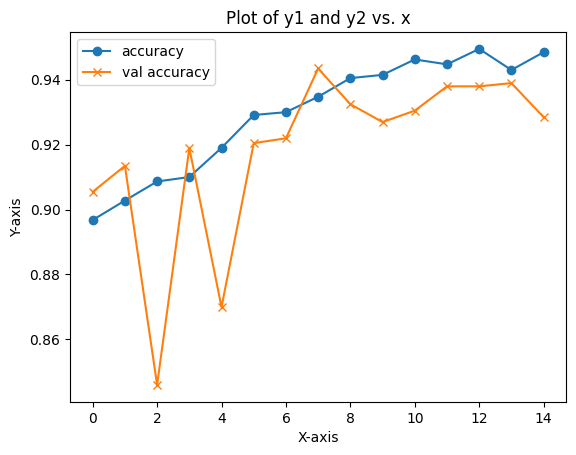

In [35]:
# plotting the train accuracy against validation accuracy

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
x = [i for i in range(15)]

plt.plot(x, accuracy, label='train_accuracy', marker='o')  # Plot y1 against x
plt.plot(x, val_accuracy, label='val accuracy', marker='x')  # Plot y2 against x
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of y1 and y2 vs. x')
plt.legend()
plt.show()